1本のリードに含まれる synchronized units に対する表現を考える。

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.display import display
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.io as pio
pio.templates.default = 'plotly_white'
import logging
import logzero
logzero.loglevel(logging.INFO)

In [2]:
dir_fname = 'work'
import os
os.chdir(dir_fname)

In [3]:
from BITS.util.io import load_pickle, save_pickle
import numpy as np
import pandas as pd
from BITS.plot.plotly import make_hist, make_scatter, make_layout, show_plot
from BITS.clustering.seq import ClusteringSeq
import consed
from BITS.seq.align import EdlibRunner
from collections import Counter, defaultdict
from logzero import logger
from dataclasses import dataclass
from typing import List
import random

In [4]:
sync_reads = load_pickle("centromere_reads_sync.pkl")

In [5]:
centromere_phreds = load_pickle("centromere_phreds.pkl")   # Integer QV array for each centromere read extracted from fastq

In [6]:
db_prefix = "DMEL_CSS"
db_fname = f"{db_prefix}.db"
las_fname = f"TAN.{db_prefix}.las"
from vca import ReadViewer
v = ReadViewer(db_fname, las_fname)

In [7]:
read = sync_reads[1]

In [8]:
v.show(read=read)

[I 190917 11:10:39 log:17] Starting distance matrix calculation 
[I 190917 11:10:39 log:19] Finished distance matrix calculation


In [9]:
c = ClusteringSeq([read.seq[unit.start:unit.end] for unit in read.units], revcomp=False, cyclic=False)

In [17]:
c.calc_dist_mat()

[I 190915 11:12:35 log:17] Starting distance matrix calculation 
[I 190915 11:12:36 log:19] Finished distance matrix calculation


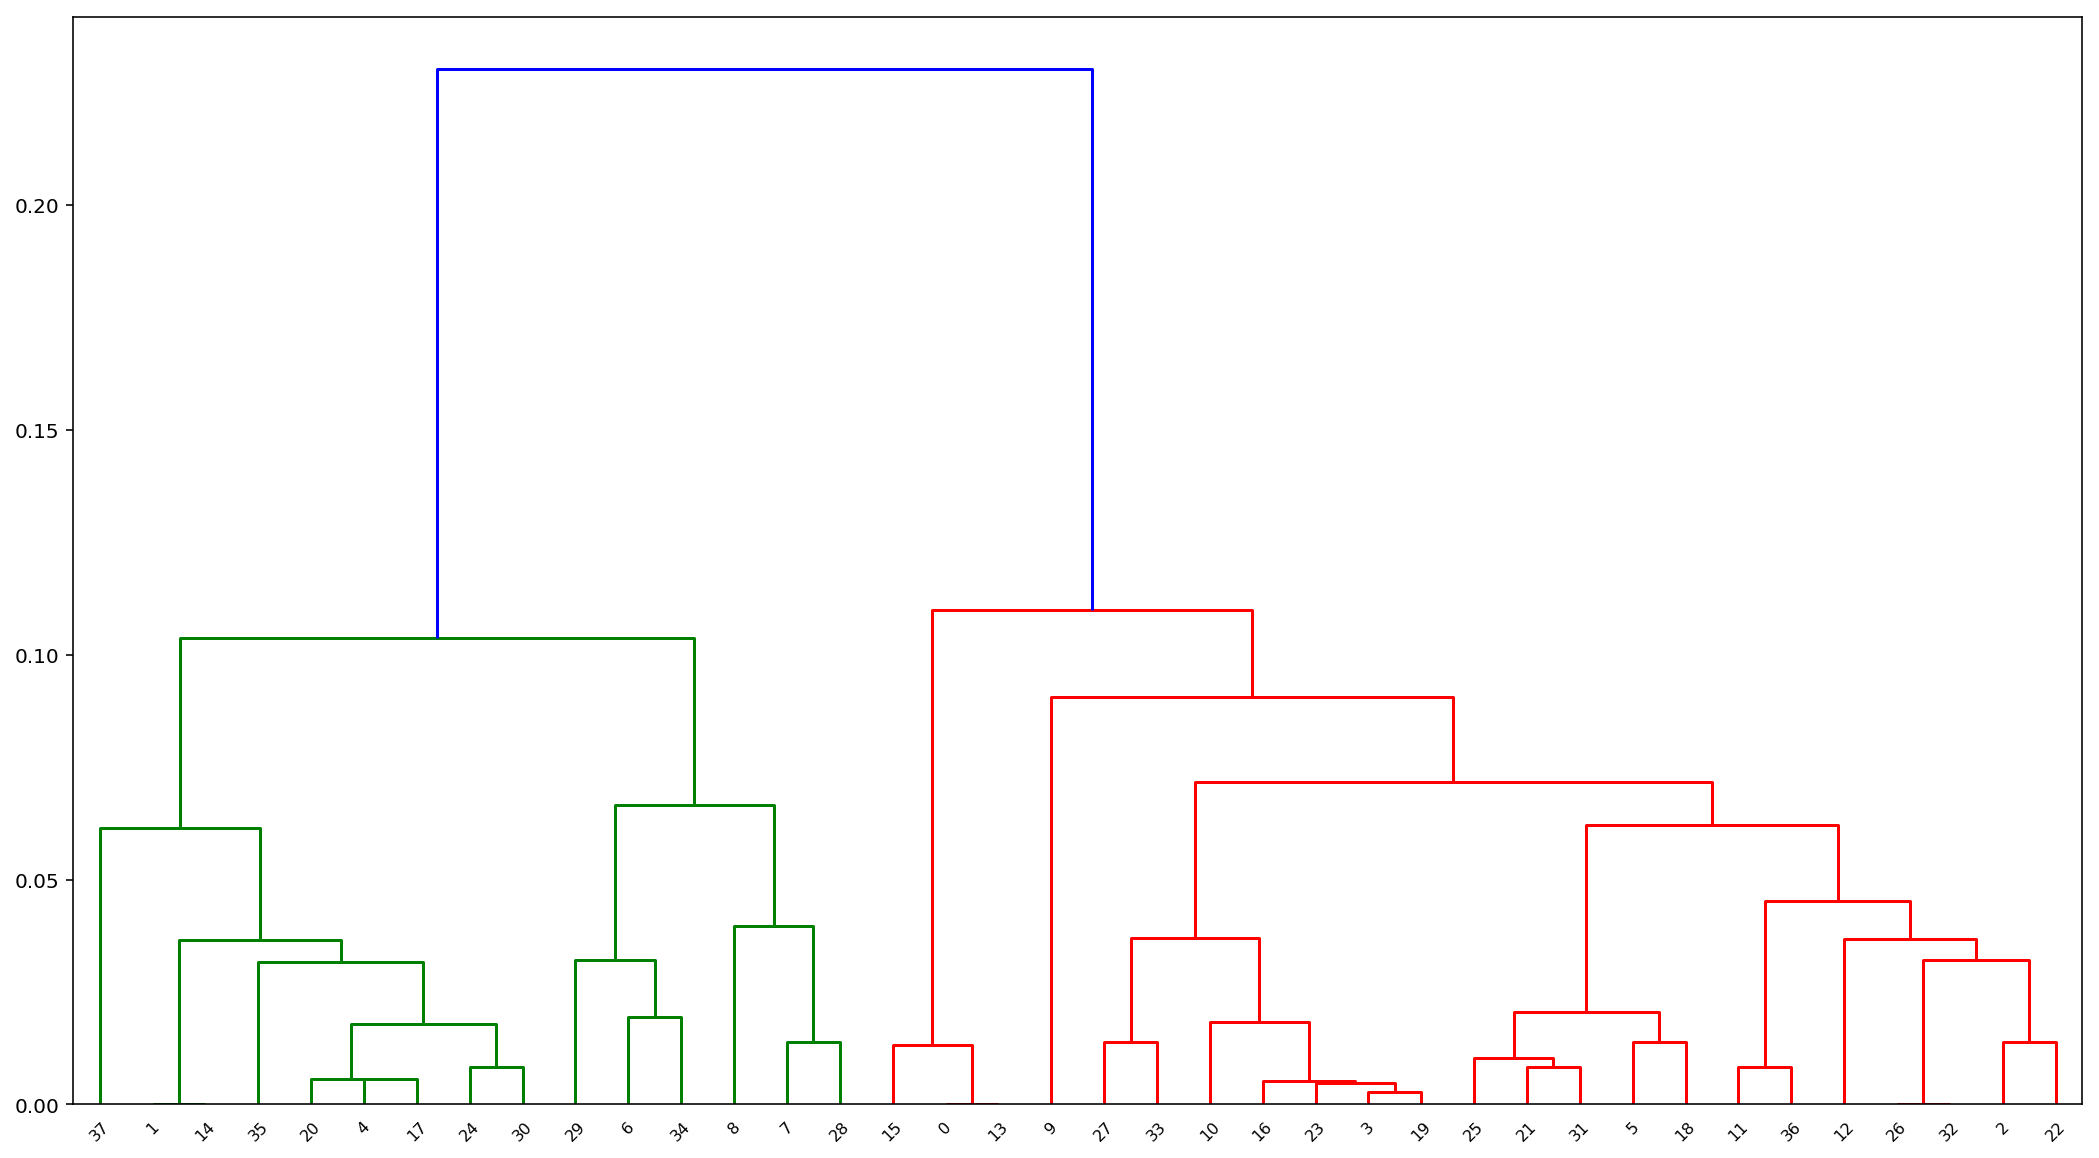

In [11]:
c.show_dendrogram()

In [12]:
show_plot([make_hist(centromere_phreds[read.name])])

In [22]:
read = sync_reads[0]

In [8]:
units = [read.seq[unit.start:unit.end] for unit in read.units]

In [60]:
c = ClusteringSeq(units, revcomp=False, cyclic=False)

In [61]:
c.calc_dist_mat()

[I 190916 04:28:39 log:17] Starting distance matrix calculation 
[I 190916 04:28:39 log:19] Finished distance matrix calculation


In [65]:
from BITS.seq.consed import ConsedRunner

In [88]:
r = ConsedRunner(variant_vector=True, variant_graph=True, min_var_frac=0.1)

In [89]:
r.run(units)

In [90]:
import plotly.graph_objects as go

In [92]:
show_plot([go.Heatmap(z=r.variant_matrix, colorscale="YlGnBu")], make_layout(500, 500))

## Functions for counting variants

In [55]:
# Variants and sequencing errors

class PairwiseAlignment:
    def __init__(self, a_seq, b_seq):
        er = EdlibRunner("global", revcomp=False, cyclic=False)
        self.fcigar = er.align(b_seq.lower(), a_seq.lower()).cigar.flatten().string   # NOTE: b vs a; be careful!
        self.source, self.target = '', ''
        s_pos, t_pos = 0, 0
        for c in self.fcigar:
            if c == '=' or c == 'X':
                self.source += a_seq[s_pos]
                self.target += b_seq[t_pos]
                s_pos += 1
                t_pos += 1
            elif c == 'I':
                self.source += '-'
                self.target += b_seq[t_pos]
                t_pos += 1
            else:
                self.source += a_seq[s_pos]
                self.target += '-'
                s_pos += 1
        
    def show(self, by_cigar=False):
        if by_cigar:   # standard alignment like BLAST
            print(self.source)
            print(self.fcigar)
            print(self.target)
        else:
            print(''.join([' ' if c == '=' else self.source[i] for i, c in enumerate(self.fcigar)]))
            print(''.join([self.source[i] if c == '=' else ' ' for i, c in enumerate(self.fcigar)]))
            print(''.join([' ' if c == '=' else self.target[i] for i, c in enumerate(self.fcigar)]))

def count_variants(cluster_cons_unit, cluster_units):
    """Given a set of unit sequences <units> in a cluster, calculate the composition of
    nucleotides including '-' (= distribution of each )
    for each position on <cluster_cons_unit> as a seed.
    from which <units> are generated, compute the variations (= nucleotides inconsistent between
    <units> and <cluster_cons_unit> and their relative frequency).
    Since a cluster should be homogeneous (i.e., mono-source), the relative frequencies are
    expected to be not much larger than sequencing error.
    """
    assert cluster_cons_unit != "", "Empty strings are not allowed"
    # TODO: how to decide "same variant?" especially for multiple variations on same position (but slightly different among units)?
    variants = Counter()   # TOOD: change to a class?
    for unit in cluster_units:
        assert unit != "", "Empty strings are not allowed"
        alignment = PairwiseAlignment(cluster_cons_unit, unit)   # alignment.fcigar(cluster_cons_unit) = unit
        tpos = 0
        var_index = 0   # positive values for continuous insertions
        for i, c in enumerate(alignment.fcigar):
            if c == '=':
                var_index = 0
            elif c == 'I':
                var_index += 1
            if c != '=':
                variants[(tpos, var_index, c, alignment.target[i])] += 1   # TODO: multiple D on the same pos are aggregated
            if c != 'I':
                tpos += 1
        assert tpos == len(cluster_cons_unit)
    return variants

def list_variations(template_unit, cluster_cons_unit):
    """Single-vs-single version of count_variants().
    That is, list up the differences between the (imaginary) template unit and the consensus unit
    of a cluster (which should be a real instance).
    The return value is [(position_on_template_unit, variant_type, base_on_cluster_cons_unit)].
    """
    assert template_unit != "" and cluster_cons_unit != "", "Empty strings are not allowed"
    return list(count_variants(template_unit, [cluster_cons_unit]).keys())

## Functions for alignment probability

In [64]:
# Probability of alignment 1) between units and 2) between a unit and a representative unit

def phred_to_log_p_correct(phred):
    return np.log10(1 - np.power(10, -phred / 10))

def phred_to_log_p_error(phred):
    return -phred / 10

def log_prob_gen(cons_unit, obs_unit, obs_qual=None, p_non_match=0.01):
    """Log likelihood of generating <obs_unit> from <cons_unit>.
    <obs_qual> is positional QVs of <obs_unit> and if not given,
    <p_non_match> is used as average error rate for every position.
    """
    if cons_unit == "":   # input sequences for <cons_unit> were empty; or, Consed did not return
        return -np.inf

    # Compute alignment
    er = EdlibRunner("global", revcomp=False)
    fcigar = er.align(cons_unit, obs_unit).cigar.flatten().string
    logger.debug(fcigar)
    
    # Calculate the sum of log probabilities for each position in the alignment
    if obs_qual is None:
        n_match = Counter(fcigar)['=']
        n_non_match = len(fcigar) - n_match
        return n_match * np.log10(1 - p_non_match) + n_non_match * np.log10(p_non_match)
    else:
        p = 0.
        pos = 0
        for c in fcigar:
            p += (phred_to_log_p_correct(obs_qual[pos]) if c == '='
                  else phred_to_log_p_error(obs_qual[pos]))
            if c in ('=', 'X', 'D'):
                pos += 1
        assert pos == len(obs_unit) == len(obs_qual), "Invalid length"
        return p

def log_prob_align(unit_x, unit_y, qual_x=None, qual_y=None, p_error=0.01):
    """Log likelihood of alignment between <unit_x> from <unit_y>.
    <qual_*> is positional QVs of <unit_*> and if not given,
    <p_error> is used as average error rate for every position of each read.
    """
    # Compute alignment
    er = EdlibRunner("global", revcomp=False)
    fcigar = er.align(unit_x, unit_y).cigar.flatten().string
    logger.debug(fcigar)
    
    # Calculate the sum of log probabilities for each position in the alignment
    if qual_x is None and qual_y is None:
        p_match = (1 - p_error) * (1 - p_error)
        n_match = Counter(fcigar)['=']
        n_non_match = len(fcigar) - n_match
        return n_match * np.log10(p_match) + n_non_match * np.log10(1 - p_match)
    else:
        p = 0.
        pos_x = pos_y = 0
        for c in fcigar:   # fcigar(unit_y) = unit_x
            p_match = phred_to_log_p_correct(qual_x[pos_x]) + phred_to_log_p_correct(qual_y[pos_y])
            p += (p_match if c == '='
                  else np.log10(1 - np.power(10, p_match)))
            if c in ('=', 'X', 'I'):
                pos_x += 1
            if c in ('=', 'X', 'D'):
                pos_y += 1
        assert pos_x == len(unit_x) == len(qual_x) and pos_y == len(unit_y) == len(qual_y), "Invalid length"
        return p
    
def log_factorial(n):
    return np.sum([np.log10(i) for i in range(1, n + 1)])
    
def log_prob_composition(cons_unit, obs_units, p_error=0.001):   # TODO: use positional QVs
    """Log likelihood of composition of <obs_units> given <cons_unit> as a seed; i.e., probability of alignment pileup.
    <p_error> is used for average sequencing error rate (= non-match rate in a single alignment).
    Concretely, compute Multinomial(n_A, ..., n_-; p_A, ..., p_-) for each position, where p_X = 1 - p_error
    if X is the base of <cons_unit>, otherwise p_X = p_error.
    """
    var_counts = count_variants(cons_unit, obs_units)
    var_pos = [pos for pos, index, op, base in var_counts.keys()]
    
    # compute for matches
    n_matches = len(cons_unit) - len(set(var_pos))
    p_match = n_matches * len(obs_units) * np.log10(1 - p_error)
    
    # compute for variants
    var_freqs = defaultdict(Counter)   # {(pos, index): Counter('A': n_A, ..., '-': n_-)} for each variant column
    for (pos, index, op, base), count in var_counts.items():   # list up frequencies of each variant for each position
        var_freqs[(pos, index)][base] = count
    log_factorial_N = log_factorial(len(obs_units))
    p_var = 0.
    for key, counts in var_freqs.items():   # for each variant position
        p_var += log_factorial_N
        for base, count in counts.items():
            p_var -= log_factorial(count)
            p_var += count * np.log10(p_error)
        n_match = len(obs_units) - np.sum(list(counts.values()))   # number of units having base same as seed
        p_var -= log_factorial(n_match)
        p_var += n_match * np.log10(1 - p_error)

    return p_match + p_var

## Class for Split-merge sampling (新しい方が固まり次第削除)

In [9]:
@dataclass(eq=False)
class SplitMergeClustering:
    units: List[str]
    quals: np.ndarray
    
    def __post_init__(self):
        self.N = len(self.units)   # number of data
        self.assignments = np.zeros([self.N], dtype=np.int16)   # cluster assignments

        # Compute all-vs-all unit alignment likelihood
        self.log_p_mat = np.zeros([self.N, self.N], dtype=np.float32)
        for i in range(self.N):
            for j in range(i + 1, self.N):
                self.log_p_mat[i][j] = self.log_p_mat[j][i] = log_prob_align(self.units[i], self.units[j],
                                                                            self.quals[i], self.quals[j])
                
        # Compute probability of initial clustering state
        self.p_total = self.log_prob_cluster(0)   # TODO: include partition probability   # TODO: to property?
        
        # Compute consensus unit of the whole units so that comparing clusters can be easy
        self.template_unit = self.cluster_cons(0)
        
    def show_clustering(self):
        er = EdlibRunner("global", revcomp=False)
        for cluster_id in np.unique(self.assignments):
            print(f"Cluster {cluster_id} ({len(self.cluster_units(cluster_id))} units):\n"
                  f"{self.cluster_unit_ids(cluster_id)}\n"
                  f"{self.cluster_cons(cluster_id)}\n"
                  f"{er.align(self.cluster_cons(cluster_id), self.template_unit).cigar.flatten().string}")
            print("---")
            for unit in self.cluster_units(cluster_id):
                print(f"{er.align(unit, self.cluster_cons(cluster_id)).cigar.flatten().string}")
            
    def cluster_unit_ids(self, cluster_id, assignments=None, exclude_unit=None):
        """Return indices of the units belonging to the cluster <cluster_id> given a clustering state <assignments>,
        while excluding a unit <exclude_unit> if provided."""
        return [i for i in range(self.N)
                if i != exclude_unit and (self.assignments if assignments is None else assignments)[i] == cluster_id]

    def cluster_units(self, cluster_id, assignments=None, exclude_unit=None):
        """Return unit sequences belonging to the cluster <cluster_id> given a clustering state <assignments>,
        while excluding a unit <exclude_unit> if provided."""
        return [self.units[i] for i in self.cluster_unit_ids(cluster_id, assignments, exclude_unit)]

    def cluster_cons(self, cluster_id, assignments=None, exclude_unit=None):
        """Return the consensus sequence of the units belonging to the cluster <cluster_id> given a clustering state <assignments>,
        while excluding a unit <exclude_unit> if provided."""
        cluster_units = self.cluster_units(cluster_id, assignments, exclude_unit)   # units belonging to the cluster
        if len(cluster_units) == 0:   # cluster with single unit which is excluded
            return ""
        elif len(cluster_units) == 1:   # cluster with single unit
            return cluster_units[0]   # TODO: NOTE: single data cluster can be harmful!
        else:
            return consed.consensus(cluster_units)
                
    def log_prob_cluster(self, cluster_id, assignments=None):
        """Return log probability of the cluster <cluster_id> given a clustering state <assignments>"""
        cons = self.cluster_cons(cluster_id, assignments)
        if cons == "":   # Consed did not return
            return -np.inf
        return np.sum([log_prob_gen(cons, unit) for unit in self.cluster_units(cluster_id, assignments)])
        
    def gibbs_sampling_single(self, unit_id, cluster_ids, assignments):
        """Compute probability of the unit assignment for each cluster while excluding the unit."""
        weights = tuple(map(lambda log_p: np.power(10, log_p),
                            [log_prob_gen(self.cluster_cons(cluster_id, assignments, exclude_unit=unit_id),
                                          self.units[unit_id])
                             for cluster_id in cluster_ids]))   # TODO: possibility of create a new cluster
        new_assignment = random.choices(cluster_ids, weights=weights)[0]   # sample a new cluster assignment based on the probabilities
        logger.info(f"weights: {weights}, {assignments[unit_id]} -> {new_assignment}")
        return new_assignment
        
    def gibbs_sampling(self, unit_ids, cluster_ids, assignments, n_iter=2):
        """Re-assign each unit of <unit_ids> into one of the clusters <cluster_ids>,
        Given a clustering state <assignments>.
        """
        for t in range(n_iter):
            for unit_id in unit_ids:
                assignments[unit_id] = self.gibbs_sampling_single(unit_id, cluster_ids, assignments)
        return assignments
    
    def do_gibbs(self, n_iter=2):
        """Run a single iteration of Gibbs sampling with all units."""
        self.assignments = self.gibbs_sampling(list(range(self.N)), np.unique(self.assignments), self.assignments, n_iter)
        logger.info(f"State prob before Gibbs sampling: {self.p_total}")
        self.p_total = np.sum([self.log_prob_cluster(cluster_id) for cluster_id in np.unique(self.assignments)])
        logger.info(f"State prob after Gibbs sampling: {self.p_total}")
    
    def do_proposal(self, n_iter=100):
        """Propose a new state by choosing random two units."""
        for t in range(n_iter):
            x, y = random.sample(list(range(self.N)), 2)
            logger.info(f"Selected: {x}({self.assignments[x]}) and {y}({self.assignments[y]})")
            if self.assignments[x] == self.assignments[y]:
                logger.info("Split")
                self.propose_split(x, y)
            else:
                logger.info("Merge")
                self.propose_merge(x, y)

    def propose_split(self, x, y, n_gibbs_iter=3):
        assert self.assignments[x] == self.assignments[y], "Must belong to the same cluster"
        
        # Split cluster <old_cluster_id> into <old_cluster_id> and <new_cluster_id>
        old_cluster_id = self.assignments[x]
        new_cluster_id = np.max(self.assignments) + 1
        new_assignments = np.copy(self.assignments)
        
        # Assign each unit to one of x and y with higher alignment likelihood   # TODO: random init assignment?
        new_assignments[y] = new_cluster_id
        for i in range(self.N):
            if i != x and i != y and new_assignments[i] == old_cluster_id:
                if self.log_p_mat[i][x] < self.log_p_mat[i][y]:
                    new_assignments[i] = new_cluster_id
        logger.info(f"\nCurrent state:\n{self.assignments}\nProposed state (init):\n{new_assignments}")
        
        # Re-assign each unit to one of the new clusters (= Gibbs sampling)
        self.gibbs_sampling(self.cluster_unit_ids(old_cluster_id),
                            (old_cluster_id, new_cluster_id),
                            new_assignments, n_iter=2)
        logger.info(f"\nCurrent state:\n{self.assignments}\nProposed state (Gibbs):\n{new_assignments}")
        
        # Compare the probability of the current state and the proposed state
        p_old_cluster = self.log_prob_cluster(old_cluster_id)
        p_new_cluster = (self.log_prob_cluster(old_cluster_id, new_assignments)
                         + self.log_prob_cluster(new_cluster_id, new_assignments))
        new_p_total = self.p_total - p_old_cluster + p_new_cluster
        logger.info(f"Current state prob: {self.p_total}, Proposed state prob: {new_p_total}")
        if self.p_total < new_p_total:
            logger.info("Accepted")
            self.p_total = new_p_total
            self.assignments = new_assignments
        else:
            logger.info("Rejected")
            
    def propose_merge(self, x, y):
        assert self.assignments[x] != self.assignments[y], "Must belong to different clusters"
        
        # Merge cluster <old_cluster_id_x> and <old_cluster_id_y> into <old_cluster_id_x>
        old_cluster_id_x = self.assignments[x]
        old_cluster_id_y = self.assignments[y]
        new_assignments = np.copy(self.assignments)
        
        # Change cluster assignment of the units in the cluster which units[y] belongs to
        for i in range(self.N):
            if new_assignments[i] == old_cluster_id_y:
                new_assignments[i] = old_cluster_id_x
        logger.info(f"\nCurrent state:\n{self.assignments}\nProposed state:\n{new_assignments}")
        
        # Compare the probability of the current state and the proposed state
        p_old_cluster = (self.log_prob_cluster(old_cluster_id_x)
                         + self.log_prob_cluster(old_cluster_id_y))
        p_new_cluster = self.log_prob_cluster(old_cluster_id_x, new_assignments)
        new_p_total = self.p_total - p_old_cluster + p_new_cluster
        logger.info(f"Current state prob: {self.p_total}, Proposed state prob: {new_p_total}")
        if self.p_total < new_p_total:
            logger.info("Accepted")
            self.p_total = new_p_total
            self.assignments = new_assignments
        else:
            logger.info("Rejected")

In [10]:
smc = SplitMergeClustering([read.seq[unit.start:unit.end] for unit in read.units],
                           [centromere_phreds[read.name][unit.start:unit.end] for unit in read.units])

In [11]:
smc.log_p_mat

array([[   0.      , -201.68346 , -119.009834, ..., -234.69757 ,
        -148.79634 , -189.88011 ],
       [-201.68346 ,    0.      , -124.35283 , ...,  -84.709526,
        -135.29305 , -176.1989  ],
       [-119.009834, -124.35283 ,    0.      , ..., -208.66441 ,
         -76.216515, -183.25117 ],
       ...,
       [-234.69757 ,  -84.709526, -208.66441 , ...,    0.      ,
        -182.74564 , -112.65529 ],
       [-148.79634 , -135.29305 ,  -76.216515, ..., -182.74564 ,
           0.      , -160.83798 ],
       [-189.88011 , -176.1989  , -183.25117 , ..., -112.65529 ,
        -160.83798 ,    0.      ]], dtype=float32)

In [12]:
smc.p_total

-999.5368648150969

In [16]:
smc.do_proposal()

[I 190917 01:33:48 <ipython-input-9-c49817364190>:93] Selected: 32(0) and 37(8)
[I 190917 01:33:48 <ipython-input-9-c49817364190>:98] Merge
[I 190917 01:33:48 <ipython-input-9-c49817364190>:148] 
    Current state:
    [2 8 7 4 8 7 1 8 8 7 4 7 7 2 8 2 4 8 3 4 8 7 7 4 5 3 0 7 1 6 5 7 0 7 6 8 7
     8]
    Proposed state:
    [2 0 7 4 0 7 1 0 0 7 4 7 7 2 0 2 4 0 3 4 0 7 7 4 5 3 0 7 1 6 5 7 0 7 6 0 7
     0]
[I 190917 01:33:49 <ipython-input-9-c49817364190>:155] Current state prob: -438.4927571982337, Proposed state prob: -508.339989009148
[I 190917 01:33:49 <ipython-input-9-c49817364190>:161] Rejected
[I 190917 01:33:49 <ipython-input-9-c49817364190>:93] Selected: 35(8) and 30(5)
[I 190917 01:33:49 <ipython-input-9-c49817364190>:98] Merge
[I 190917 01:33:49 <ipython-input-9-c49817364190>:148] 
    Current state:
    [2 8 7 4 8 7 1 8 8 7 4 7 7 2 8 2 4 8 3 4 8 7 7 4 5 3 0 7 1 6 5 7 0 7 6 8 7
     8]
    Proposed state:
    [2 8 7 4 8 7 1 8 8 7 4 7 7 2 8 2 4 8 3 4 8 7 7 4 8 3 0 7 1 6 8 7 0 

[I 190917 01:33:51 <ipython-input-9-c49817364190>:155] Current state prob: -438.4927571982337, Proposed state prob: -524.331259398343
[I 190917 01:33:51 <ipython-input-9-c49817364190>:161] Rejected
[I 190917 01:33:51 <ipython-input-9-c49817364190>:93] Selected: 24(5) and 0(2)
[I 190917 01:33:51 <ipython-input-9-c49817364190>:98] Merge
[I 190917 01:33:51 <ipython-input-9-c49817364190>:148] 
    Current state:
    [2 8 7 4 8 7 1 8 8 7 4 7 7 2 8 2 4 8 3 4 8 7 7 4 5 3 0 7 1 6 5 7 0 7 6 8 7
     8]
    Proposed state:
    [5 8 7 4 8 7 1 8 8 7 4 7 7 5 8 5 4 8 3 4 8 7 7 4 5 3 0 7 1 6 5 7 0 7 6 8 7
     8]
[I 190917 01:33:51 <ipython-input-9-c49817364190>:155] Current state prob: -438.4927571982337, Proposed state prob: -528.3225297875381
[I 190917 01:33:51 <ipython-input-9-c49817364190>:161] Rejected
[I 190917 01:33:51 <ipython-input-9-c49817364190>:93] Selected: 35(8) and 16(4)
[I 190917 01:33:51 <ipython-input-9-c49817364190>:98] Merge
[I 190917 01:33:51 <ipython-input-9-c49817364190>:148] 

[I 190917 01:33:55 <ipython-input-9-c49817364190>:148] 
    Current state:
    [2 9 7 4 8 7 1 9 9 7 4 7 7 2 9 2 4 8 3 4 8 7 7 4 5 3 0 7 1 6 5 7 0 7 6 8 7
     8]
    Proposed state:
    [2 7 7 4 8 7 1 7 7 7 4 7 7 2 7 2 4 8 3 4 8 7 7 4 5 3 0 7 1 6 5 7 0 7 6 8 7
     8]
[I 190917 01:33:55 <ipython-input-9-c49817364190>:155] Current state prob: -408.55386447386803, Proposed state prob: -506.37927225777
[I 190917 01:33:55 <ipython-input-9-c49817364190>:161] Rejected
[I 190917 01:33:55 <ipython-input-9-c49817364190>:93] Selected: 0(2) and 26(0)
[I 190917 01:33:55 <ipython-input-9-c49817364190>:98] Merge
[I 190917 01:33:55 <ipython-input-9-c49817364190>:148] 
    Current state:
    [2 9 7 4 8 7 1 9 9 7 4 7 7 2 9 2 4 8 3 4 8 7 7 4 5 3 0 7 1 6 5 7 0 7 6 8 7
     8]
    Proposed state:
    [2 9 7 4 8 7 1 9 9 7 4 7 7 2 9 2 4 8 3 4 8 7 7 4 5 3 2 7 1 6 5 7 2 7 6 8 7
     8]
[I 190917 01:33:55 <ipython-input-9-c49817364190>:155] Current state prob: -408.55386447386803, Proposed state prob: -490.374

[I 190917 01:33:59 <ipython-input-9-c49817364190>:161] Rejected
[I 190917 01:33:59 <ipython-input-9-c49817364190>:93] Selected: 3(4) and 0(2)
[I 190917 01:33:59 <ipython-input-9-c49817364190>:98] Merge
[I 190917 01:33:59 <ipython-input-9-c49817364190>:148] 
    Current state:
    [ 2  9  7  4  8  7  1  9  9  7  4 10  7  2  9  2  4  8  3  4  8  7  7  4
      5  3  0  7  1  6  5  7  0  7  6  8 10  8]
    Proposed state:
    [ 4  9  7  4  8  7  1  9  9  7  4 10  7  4  9  4  4  8  3  4  8  7  7  4
      5  3  0  7  1  6  5  7  0  7  6  8 10  8]
[I 190917 01:33:59 <ipython-input-9-c49817364190>:155] Current state prob: -384.60187733329496, Proposed state prob: -486.4840275874288
[I 190917 01:33:59 <ipython-input-9-c49817364190>:161] Rejected
[I 190917 01:33:59 <ipython-input-9-c49817364190>:93] Selected: 31(7) and 37(8)
[I 190917 01:33:59 <ipython-input-9-c49817364190>:98] Merge
[I 190917 01:33:59 <ipython-input-9-c49817364190>:148] 
    Current state:
    [ 2  9  7  4  8  7  1  9  9  7  4 

[I 190917 01:34:02 <ipython-input-9-c49817364190>:148] 
    Current state:
    [ 2  9 11  4  8 11  1  9  9 11  4 10 11  2  9  2  4  8  3  4  8 11 11  4
      5  3  0  7  1  6  5 11  0  7  6  8 10  8]
    Proposed state:
    [ 2  9 11  4  8 11  1  9  9 11  4 10 11  2  9  2  4  8  3  4  8 11 11  4
      5  3  1  7  1  6  5 11  1  7  6  8 10  8]
[I 190917 01:34:02 <ipython-input-9-c49817364190>:155] Current state prob: -364.61933655490475, Proposed state prob: -430.48839239283126
[I 190917 01:34:02 <ipython-input-9-c49817364190>:161] Rejected
[I 190917 01:34:02 <ipython-input-9-c49817364190>:93] Selected: 2(11) and 14(9)
[I 190917 01:34:02 <ipython-input-9-c49817364190>:98] Merge
[I 190917 01:34:02 <ipython-input-9-c49817364190>:148] 
    Current state:
    [ 2  9 11  4  8 11  1  9  9 11  4 10 11  2  9  2  4  8  3  4  8 11 11  4
      5  3  0  7  1  6  5 11  0  7  6  8 10  8]
    Proposed state:
    [ 2 11 11  4  8 11  1 11 11 11  4 10 11  2 11  2  4  8  3  4  8 11 11  4
      5  3  0  7 

[I 190917 01:34:05 <ipython-input-9-c49817364190>:155] Current state prob: -364.61933655490475, Proposed state prob: -466.45347394961163
[I 190917 01:34:05 <ipython-input-9-c49817364190>:161] Rejected
[I 190917 01:34:05 <ipython-input-9-c49817364190>:93] Selected: 20(8) and 23(4)
[I 190917 01:34:05 <ipython-input-9-c49817364190>:98] Merge
[I 190917 01:34:05 <ipython-input-9-c49817364190>:148] 
    Current state:
    [ 2  9 11  4  8 11  1  9  9 11  4 10 11  2  9  2  4  8  3  4  8 11 11  4
      5  3  0  7  1  6  5 11  0  7  6  8 10  8]
    Proposed state:
    [ 2  9 11  8  8 11  1  9  9 11  8 10 11  2  9  2  8  8  3  8  8 11 11  8
      5  3  0  7  1  6  5 11  0  7  6  8 10  8]
[I 190917 01:34:05 <ipython-input-9-c49817364190>:155] Current state prob: -364.61933655490475, Proposed state prob: -548.2265040686843
[I 190917 01:34:05 <ipython-input-9-c49817364190>:161] Rejected
[I 190917 01:34:05 <ipython-input-9-c49817364190>:93] Selected: 16(4) and 32(0)
[I 190917 01:34:05 <ipython-input-

[I 190917 01:34:07 <ipython-input-9-c49817364190>:155] Current state prob: -364.61933655490475, Proposed state prob: -510.33125939834304
[I 190917 01:34:07 <ipython-input-9-c49817364190>:161] Rejected
[I 190917 01:34:07 <ipython-input-9-c49817364190>:93] Selected: 1(9) and 9(11)
[I 190917 01:34:07 <ipython-input-9-c49817364190>:98] Merge
[I 190917 01:34:07 <ipython-input-9-c49817364190>:148] 
    Current state:
    [ 2  9 11  4  8 11  1  9  9 11  4 10 11  2  9  2  4  8  3  4  8 11 11  4
      5  3  0  7  1  6  5 11  0  7  6  8 10  8]
    Proposed state:
    [ 2  9  9  4  8  9  1  9  9  9  4 10  9  2  9  2  4  8  3  4  8  9  9  4
      5  3  0  7  1  6  5  9  0  7  6  8 10  8]
[I 190917 01:34:08 <ipython-input-9-c49817364190>:155] Current state prob: -364.61933655490475, Proposed state prob: -466.45347394961163
[I 190917 01:34:08 <ipython-input-9-c49817364190>:161] Rejected
[I 190917 01:34:08 <ipython-input-9-c49817364190>:93] Selected: 29(6) and 14(9)
[I 190917 01:34:08 <ipython-input-

[I 190917 01:34:10 <ipython-input-9-c49817364190>:155] Current state prob: -364.61933655490475, Proposed state prob: -510.33125939834304
[I 190917 01:34:10 <ipython-input-9-c49817364190>:161] Rejected
[I 190917 01:34:10 <ipython-input-9-c49817364190>:93] Selected: 21(11) and 35(8)
[I 190917 01:34:10 <ipython-input-9-c49817364190>:98] Merge
[I 190917 01:34:10 <ipython-input-9-c49817364190>:148] 
    Current state:
    [ 2  9 11  4  8 11  1  9  9 11  4 10 11  2  9  2  4  8  3  4  8 11 11  4
      5  3  0  7  1  6  5 11  0  7  6  8 10  8]
    Proposed state:
    [ 2  9 11  4 11 11  1  9  9 11  4 10 11  2  9  2  4 11  3  4 11 11 11  4
      5  3  0  7  1  6  5 11  0  7  6 11 10 11]
[I 190917 01:34:10 <ipython-input-9-c49817364190>:155] Current state prob: -364.61933655490475, Proposed state prob: -510.33125939834304
[I 190917 01:34:10 <ipython-input-9-c49817364190>:161] Rejected
[I 190917 01:34:10 <ipython-input-9-c49817364190>:93] Selected: 37(8) and 20(8)
[I 190917 01:34:10 <ipython-inpu

[I 190917 01:34:13 <ipython-input-9-c49817364190>:161] Rejected
[I 190917 01:34:13 <ipython-input-9-c49817364190>:93] Selected: 27(7) and 6(1)
[I 190917 01:34:13 <ipython-input-9-c49817364190>:98] Merge
[I 190917 01:34:13 <ipython-input-9-c49817364190>:148] 
    Current state:
    [ 2  9 11  4  8 11  1  9  9 11  4 10 11  2  9  2  4  8  3  4  8 11 11  4
      5  3  0  7  1  6  5 11  0  7  6  8 10  8]
    Proposed state:
    [ 2  9 11  4  8 11  7  9  9 11  4 10 11  2  9  2  4  8  3  4  8 11 11  4
      5  3  0  7  7  6  5 11  0  7  6  8 10  8]
[I 190917 01:34:13 <ipython-input-9-c49817364190>:155] Current state prob: -364.61933655490475, Proposed state prob: -426.50585161444104
[I 190917 01:34:13 <ipython-input-9-c49817364190>:161] Rejected
[I 190917 01:34:13 <ipython-input-9-c49817364190>:93] Selected: 19(4) and 5(11)
[I 190917 01:34:13 <ipython-input-9-c49817364190>:98] Merge
[I 190917 01:34:13 <ipython-input-9-c49817364190>:148] 
    Current state:
    [ 2  9 11  4  8 11  1  9  9 11  

[I 190917 01:34:15 <ipython-input-9-c49817364190>:161] Rejected
[I 190917 01:34:15 <ipython-input-9-c49817364190>:93] Selected: 22(11) and 29(6)
[I 190917 01:34:15 <ipython-input-9-c49817364190>:98] Merge
[I 190917 01:34:15 <ipython-input-9-c49817364190>:148] 
    Current state:
    [ 2  9 11  4  8 11  1  9  9 11  4 10 11  2  9  2  4  8  3  4  8 11 11  4
      5  3  0  7  1  6  5 11  0  7  6  8 10  8]
    Proposed state:
    [ 2  9 11  4  8 11  1  9  9 11  4 10 11  2  9  2  4  8  3  4  8 11 11  4
      5  3  0  7  1 11  5 11  0  7 11  8 10  8]
[I 190917 01:34:15 <ipython-input-9-c49817364190>:155] Current state prob: -364.61933655490475, Proposed state prob: -440.48839239283126
[I 190917 01:34:15 <ipython-input-9-c49817364190>:161] Rejected
[I 190917 01:34:15 <ipython-input-9-c49817364190>:93] Selected: 14(9) and 24(5)
[I 190917 01:34:15 <ipython-input-9-c49817364190>:98] Merge
[I 190917 01:34:15 <ipython-input-9-c49817364190>:148] 
    Current state:
    [ 2  9 11  4  8 11  1  9  9 11

[I 190917 01:34:18 <ipython-input-9-c49817364190>:70] weights: (0.0, 0.00027377870564111517), 12 -> 12
[I 190917 01:34:18 <ipython-input-9-c49817364190>:70] weights: (0.0, 0.0271040918584704), 12 -> 12
[I 190917 01:34:18 <ipython-input-9-c49817364190>:70] weights: (0.0, 0.00027377870564111517), 12 -> 12
[I 190917 01:34:18 <ipython-input-9-c49817364190>:121] 
    Current state:
    [ 2  9 11  4  8 11  1  9  9 11  4 10 11  2  9  2  4  8  3  4  8 11 11  4
      5  3  0  7  1  6  5 11  0  7  6  8 10  8]
    Proposed state (Gibbs):
    [ 2  9 11 12  8 11  1  9  9 11 12 10 11  2  9  2 12  8  3 12  8 11 11 12
      5  3  0  7  1  6  5 11  0  7  6  8 10  8]
[I 190917 01:34:18 <ipython-input-9-c49817364190>:128] Current state prob: -364.61933655490475, Proposed state prob: -inf
[I 190917 01:34:18 <ipython-input-9-c49817364190>:134] Rejected


In [17]:
smc.do_gibbs()

[I 190917 01:34:19 <ipython-input-9-c49817364190>:70] weights: (3.381119958764996e-46, 3.701210861730973e-68, 2.9969735809067786e-06, 3.3138356715855824e-38, 3.280697314869758e-40, 3.449770389516418e-52, 3.853035847745142e-76, 3.3473087591773786e-42, 3.381119958764996e-48, 3.6275567655825376e-62, 3.3473087591773786e-42, 3.247890341721039e-36), 2 -> 2
[I 190917 01:34:19 <ipython-input-9-c49817364190>:70] weights: (3.1199105031747852e-30, 3.1832573239208e-34, 3.484616555067055e-54, 3.1832573239208e-36, 3.1832573239208e-38, 2.996973580906785e-20, 3.151424750681571e-36, 3.3473087591773783e-46, 2.937333806646736e-16, 2.878880863894463e-12, 3.247890341721039e-38, 3.119910503174785e-32), 9 -> 9
[I 190917 01:34:20 <ipython-input-9-c49817364190>:70] weights: (2.9670038450977214e-20, 3.449770389516418e-52, 3.2806973148697586e-36, 2.967003845097709e-16, 2.9373338066467244e-18, 3.280697314869758e-40, 3.484616555067055e-58, 3.119910503174785e-28, 3.280697314869758e-40, 3.247890341721039e-38, 3.0887

[I 190917 01:34:35 <ipython-input-9-c49817364190>:70] weights: (3.247890341721039e-38, 3.3473087591773785e-44, 3.449770389516418e-52, 3.381119958764996e-48, 3.381119958764996e-50, 2.82159113470296e-08, 3.381119958764996e-50, 3.484616555067055e-54, 2.8500920552555226e-10, 3.119910503174785e-28, 3.2478903417210392e-40, 3.3473087591773783e-46), 5 -> 5
[I 190917 01:34:36 <ipython-input-9-c49817364190>:70] weights: (3.088711398143017e-28, 3.4497703895164177e-54, 3.2806973148697586e-36, 0.0, 3.0578242841615915e-26, 3.381119958764996e-48, 3.484616555067055e-58, 3.119910503174785e-28, 3.3138356715855825e-44, 3.3138356715855825e-44, 3.119910503174785e-28, 2.878880863894463e-10), 3 -> 11
[I 190917 01:34:36 <ipython-input-9-c49817364190>:70] weights: (0.0271040918584704, 3.449770389516418e-52, 3.381119958764996e-46, 0.0, 2.9670038450977213e-22, 3.247890341721039e-38, 3.4497703895164177e-54, 3.0578242841615915e-26, 3.280697314869758e-40, 3.247890341721039e-38, 3.0578242841615915e-26, 2.99697358090

[I 190917 01:34:50 <ipython-input-9-c49817364190>:70] weights: (2.9969735809067844e-22, 3.449770389516418e-52, 3.280697314869758e-40, 0.0, 3.1199105031747852e-30, 3.1832573239208e-36, 3.484616555067055e-56, 3.2154114383038596e-34, 3.1832573239208e-36, 3.313835671585583e-42, 2.82159113470296e-08, 3.088711398143017e-26), 10 -> 10
[I 190917 01:34:51 <ipython-input-9-c49817364190>:70] weights: (2.9969735809067844e-22, 3.415272685621231e-52, 3.449770389516418e-50, 0.0, 3.1514247506815707e-34, 3.3473087591773785e-44, 3.415272685621231e-54, 3.247890341721039e-38, 3.280697314869758e-40, 3.21541143830386e-38, 3.1514247506815964e-32, 3.02724604131998e-24), 11 -> 0
[I 190917 01:34:52 <ipython-input-9-c49817364190>:70] weights: (3.381119958764996e-46, 3.701210861730973e-68, 2.9969735809067786e-06, 0.0, 3.280697314869758e-40, 3.449770389516418e-52, 3.853035847745142e-76, 3.3473087591773786e-42, 3.381119958764996e-48, 3.6275567655825376e-62, 3.3473087591773786e-42, 3.247890341721039e-34), 2 -> 2
[I 

[I 190917 01:35:06 <ipython-input-9-c49817364190>:70] weights: (3.02724604131998e-24, 3.484616555067055e-54, 3.3138356715855824e-40, 0.0, 3.1514247506815964e-32, 3.21541143830386e-38, 3.484616555067055e-54, 3.247890341721039e-36, 3.21541143830386e-38, 3.3473087591773785e-44, 2.82159113470296e-08, 3.0578242841615913e-24), 10 -> 10
[I 190917 01:35:07 <ipython-input-9-c49817364190>:70] weights: (3.3473087591773785e-44, 3.5198147020879576e-56, 3.484616555067055e-52, 0.0, 3.449770389516418e-52, 3.280697314869758e-38, 3.701210861730973e-68, 3.5553683859473977e-56, 3.1514247506815965e-30, 3.3473087591773785e-44, 3.3138356715855825e-44, 3.3473087591773785e-44), 8 -> 8
[I 190917 01:35:07 <ipython-input-9-c49817364190>:85] State prob before Gibbs sampling: -364.61933655490475
[I 190917 01:35:07 <ipython-input-9-c49817364190>:87] State prob after Gibbs sampling: -372.6018773332949


In [18]:
smc.show_clustering()

Cluster 0 (3 units):
[12, 26, 32]
atgacccccctccttacaaaaaatgcgaaaattgatccaaaaattaatttccctaaatccttcaaaaagtaatagggatcgttagcaatggtaattagctgctcaaaacagttattcttacatctatgtgaccattgctagccaagttataacgaaaatttcgtttgtaaatatctacatttttgcagagtctgtttttccaaatttcggtcatcaaaaaatcatttattttgccacaacataaaaaataattgtctgaatatggaatgtcatacctcactgagctcgtaataaaatttccaatcaaactgtgttcaaaaatggaaattaaattttttggccatatttggcaaattttg
====================================================I==================================X============================X===================XX=====================================X==========================================X=================================================================================================================================X==========
---
========X====X=================================X==============X========================X============================================X===XX=====================================X===========================X======================================

===================================================================I======================================================================XI==========================================================================================================================================================================================================================
Cluster 6 (2 units):
[29, 34]
atgaccaccctccttacaaaaaatgcgaaaagtgattcaaaaattaatttccctaaatccttcaaaaagtaacagagatcgttagcactggtaattagctgcttaaaacagttattgttacatatatgtgacaatttttagccaagttatgacgaaaatttcgtttgtaaatatcatttctttggcagaatctgtttttccaatttcggtcatcaaataatcatttatattgccacaacataaaaaaaaattgtctgaatatggaatgtcatacctcactgagctcgtaataaaatttccaatcaaactgtgttcaaaaatggaaaataaattttttggcatatttagcaaattttg
======X========================X====X===============I===================X==X===========================X===================X========X=================X=========================XDD==I====I====X=============D=========================X==================X==

Cluster 10 (2 units):
[11, 36]
atgacccccctccttacaaaaaatgcgaaaattgaaccaaaaattaatttcctaaatccttcaaaaagtaatagggatcgttagcactggaaattagctgctcaaaacagttattcttacatctatgtgaccatttttagccaagttataacgaaaatttcgtttgtaaatatctacatttttgcagagtctgtttttccaatttcggtcatcaaataatcatttattttgccacaacataaaaaataattgtctgaatatggaatgtcatacctctttgagctcgtaataaaatttccaatcaaactgtgttcaaaaatggaaattaaatttattggccatattttgcaaattttg
===================================X======================================================X========================X==========================================================X===========================D==========================================================================XX=======================================================X=======================
---
===================================X======================================================X===============================================================================================================I=============================================

In [22]:
for cluster_id in np.unique(smc.assignments):
    print(f"Cluster {cluster_id} ({len(smc.cluster_unit_ids(cluster_id))} units)")
    for variant in list_variations(smc.template_unit, smc.cluster_cons(cluster_id)):
        print(variant)
    print(count_variants(smc.cluster_cons(cluster_id), smc.cluster_units(cluster_id)))

Cluster 0 (3 units)
(52, 0, 'I', 'c')
(86, 0, 'X', 'a')
(115, 0, 'X', 'c')
(135, 0, 'X', 'g')
(136, 0, 'X', 'c')
(174, 0, 'X', 't')
(217, 0, 'X', 'a')
(347, 0, 'X', 'g')
Counter({(8, 0, 'X', 't'): 1, (13, 0, 'X', 'c'): 1, (47, 0, 'X', 'a'): 1, (62, 0, 'X', 't'): 1, (87, 0, 'X', 'c'): 1, (132, 0, 'X', 'a'): 1, (136, 0, 'X', 't'): 1, (137, 0, 'X', 't'): 1, (175, 0, 'X', 'a'): 1, (203, 0, 'X', 't'): 1})
Cluster 1 (2 units)
(6, 0, 'X', 'a')
(36, 0, 'X', 't')
(37, 0, 'X', 'a')
(52, 0, 'I', 'c')
(74, 0, 'X', 'a')
(102, 0, 'X', 't')
(131, 0, 'X', 'a')
(160, 0, 'X', 'a')
(164, 0, 'D', '-')
(176, 0, 'X', 'a')
(178, 0, 'X', 'a')
(182, 0, 'X', 'g')
(188, 0, 'X', 'a')
(232, 0, 'X', 'a')
(303, 0, 'X', 'a')
(326, 0, 'X', 'c')
(327, 0, 'X', 'a')
(340, 0, 'D', '-')
(343, 0, 'I', 't')
Counter({(150, 0, 'X', 'g'): 1, (161, 0, 'X', 'c'): 1, (165, 0, 'I', 't'): 1, (175, 0, 'X', 't'): 1, (176, 0, 'X', 't'): 1, (177, 0, 'X', 't'): 1, (178, 0, 'X', 'c'): 1, (232, 0, 'X', 'c'): 1, (303, 0, 'X', 't'): 1, (161,

In [26]:
c = ClusteringSeq([smc.cluster_cons(cluster_id) for cluster_id in np.unique(smc.assignments)], revcomp=False)
c.calc_dist_mat()
c.plot_dist_mat(variable_scale=True)

## Change clustering probability calculation

In [11]:
@dataclass(eq=False)
class SplitMergeClustering:
    units: List[str]
    quals: np.ndarray
    alpha: float
    
    def __post_init__(self):
        self.N = len(self.units)   # number of data
        self.assignments = np.zeros([self.N], dtype=np.int16)   # cluster assignments

        # Compute all-vs-all unit alignment likelihood
        self.log_p_mat = np.zeros([self.N, self.N], dtype=np.float32)
        for i in range(self.N):
            for j in range(i + 1, self.N):
                self.log_p_mat[i][j] = self.log_p_mat[j][i] = log_prob_align(self.units[i], self.units[j],
                                                                            self.quals[i], self.quals[j])
        
        # Compute consensus unit of the whole units so that comparing clusters can be easy
        self.template_unit = self.cluster_cons(0)
        
    def show_clustering(self):
        er = EdlibRunner("global", revcomp=False)
        for cluster_id in np.unique(self.assignments):
            print(f"Cluster {cluster_id} ({len(self.cluster_units(cluster_id))} units):\n"
                  f"{self.cluster_unit_ids(cluster_id)}\n"
                  f"{self.cluster_cons(cluster_id)}\n"
                  f"{er.align(self.cluster_cons(cluster_id), self.template_unit).cigar.flatten().string}")
            print("---")
            for unit in self.cluster_units(cluster_id):
                print(f"{er.align(unit, self.cluster_cons(cluster_id)).cigar.flatten().string}")
                
    def n_units(self, cluster_id, assignments=None, exclude_unit=None):
        """Return the number of units in the cluster <cluster_id> given a clustering state <assignments>,
        while excluding a unit <exclude_unit> if provided."""
        return len(self.cluster_unit_ids(cluster_id, assignments, exclude_unit))
            
    def cluster_unit_ids(self, cluster_id, assignments=None, exclude_unit=None):
        """Return indices of the units belonging to the cluster <cluster_id> given a clustering state <assignments>,
        while excluding a unit <exclude_unit> if provided."""
        return [i for i in range(self.N)
                if i != exclude_unit and (self.assignments if assignments is None else assignments)[i] == cluster_id]

    def cluster_units(self, cluster_id, assignments=None, exclude_unit=None):
        """Return unit sequences belonging to the cluster <cluster_id> given a clustering state <assignments>,
        while excluding a unit <exclude_unit> if provided."""
        return [self.units[i] for i in self.cluster_unit_ids(cluster_id, assignments, exclude_unit)]
    
    def n_clusters(self, assignments=None):
        """Return the number of clusters."""
        return len(self.cluster_ids(self.assignments if assignments is None else assignments))

    def cluster_ids(self, assignments=None):
        """Return a list of cluster indices."""
        return np.unique(self.assignments if assignments is None else assignments)

    def cluster_cons(self, cluster_id, assignments=None, exclude_unit=None):
        """Return the consensus sequence of the units belonging to the cluster <cluster_id> given a clustering state <assignments>,
        while excluding a unit <exclude_unit> if provided."""
        cluster_units = self.cluster_units(cluster_id, assignments, exclude_unit)   # units belonging to the cluster
        if len(cluster_units) == 0:   # cluster with single unit which is excluded
            return ""
        elif len(cluster_units) == 1:   # cluster with single unit
            return cluster_units[0]   # TODO: NOTE: single data cluster can be harmful!
        else:
            return consed.consensus(cluster_units)
        
    def log_prob_ewens(self, assignments=None):
        p = self.n_clusters() * np.log10(self.alpha)
        for cluster_id in self.cluster_ids():
            for i in range(1, self.n_units(cluster_id)):
                p += np.log10(i)
        for i in range(self.N):
            p -= np.log10(self.alpha + i)
        return p
    
    def log_prob_cluster_composition(self, cluster_id, assignments=None, p_error=0.001):
        """Return log probability of the composition of the cluster <cluster_id> given a clustering state <assignments>"""
        return log_prob_composition(self.cluster_cons(cluster_id, assignments),
                                    self.cluster_units(cluster_id, assignments))

    def log_prob_units_generation(self, cluster_id, assignments=None):
        """Return log probability of generating the units belonging to a cluster <cluster_id> from the cluster
        given a clustering state <assignments>."""
        cons = self.cluster_cons(cluster_id, assignments)
        return np.sum([log_prob_gen(cons, unit) for unit in self.cluster_units(cluster_id, assignments)])
        
    def log_prob_clustering(self, assignments=None):
        """Compute the joint probability of the current clustering state."""
        # First of all, check if consensus sequence exists for every cluster
        for cluster_id in self.cluster_ids(assignments):
            cons = self.cluster_cons(cluster_id, assignments)
            if cons == "":   # Consed did not return
                return -np.inf
            
        # Probability of partition (= Ewens)
        p_ewens = self.log_prob_ewens(assignments)

        # Probability of cluster compositions
        p_cluster_compositions = np.sum([self.log_prob_cluster_composition(cluster_id, assignments)
                                         for cluster_id in self.cluster_ids(assignments)])
        
        # Probability of unit generation from each cluster
        p_gen_units = np.sum([self.log_prob_units_generation(cluster_id, assignments)
                              for cluster_id in self.cluster_ids(assignments)])

        return p_gen_units + p_cluster_compositions + p_gen_units
        
    def gibbs_sampling_single(self, unit_id, cluster_ids, assignments):
        """Compute probability of the unit assignment for each cluster while excluding the unit."""
        weights = tuple(map(lambda log_p: np.power(10, log_p),
                            [log_prob_gen(self.cluster_cons(cluster_id, assignments, exclude_unit=unit_id),
                                          self.units[unit_id])
                             for cluster_id in cluster_ids]))   # TODO: possibility of create a new cluster
        new_assignment = random.choices(cluster_ids, weights=weights)[0]   # sample a new cluster assignment based on the probabilities
        logger.info(f"weights: {weights}, {assignments[unit_id]} -> {new_assignment}")
        return new_assignment
        
    def gibbs_sampling(self, unit_ids, cluster_ids, assignments, n_iter=2):
        """Re-assign each unit of <unit_ids> into one of the clusters <cluster_ids>,
        Given a clustering state <assignments>.
        """
        for t in range(n_iter):
            for unit_id in unit_ids:
                assignments[unit_id] = self.gibbs_sampling_single(unit_id, cluster_ids, assignments)
        return assignments
    
    def do_gibbs(self, n_iter=2):
        """Run a single iteration of Gibbs sampling with all units."""
        logger.info(f"State prob before Gibbs sampling: {self.log_prob_clustering()}")
        self.assignments = self.gibbs_sampling(list(range(self.N)), self.cluster_ids(), self.assignments, n_iter)
        logger.info(f"State prob after Gibbs sampling: {self.log_prob_clustering()}")
    
    def do_proposal(self, n_iter=100):
        """Propose a new state by choosing random two units."""
        for t in range(n_iter):
            x, y = random.sample(list(range(self.N)), 2)
            logger.info(f"Selected: {x}({self.assignments[x]}) and {y}({self.assignments[y]})")
            if self.assignments[x] == self.assignments[y]:
                logger.info("Split")
                self.propose_split(x, y)
            else:
                logger.info("Merge")
                self.propose_merge(x, y)

    def propose_split(self, x, y, n_gibbs_iter=2):
        assert self.assignments[x] == self.assignments[y], "Must belong to the same cluster"
        
        # Split cluster <old_cluster_id> into <old_cluster_id> and <new_cluster_id>
        old_cluster_id = self.assignments[x]
        new_cluster_id = np.max(self.assignments) + 1
        new_assignments = np.copy(self.assignments)
        
        # Assign each unit to one of x and y with higher alignment likelihood   # TODO: random init assignment?
        new_assignments[y] = new_cluster_id
        for i in range(self.N):
            if i != x and i != y and new_assignments[i] == old_cluster_id:
                if self.log_p_mat[i][x] < self.log_p_mat[i][y]:
                    new_assignments[i] = new_cluster_id
        logger.info(f"\nCurrent state:\n{self.assignments}\nProposed state (init):\n{new_assignments}")
        
        # Re-assign each unit to one of the new clusters (= Gibbs sampling)
        self.gibbs_sampling(self.cluster_unit_ids(old_cluster_id),
                            (old_cluster_id, new_cluster_id),
                            new_assignments, n_iter=n_gibbs_iter)
        logger.info(f"\nCurrent state:\n{self.assignments}\nProposed state (Gibbs):\n{new_assignments}")
        
        # Compare the probability of the current state and the proposed state
        p_current = self.log_prob_clustering()
        p_new = self.log_prob_clustering(new_assignments)
        logger.info(f"Current state prob: {p_current}, Proposed state prob: {p_new}")
        if p_current < p_new:
            logger.info("Accepted")
            self.assignments = new_assignments
        else:
            logger.info("Rejected")
            
    def propose_merge(self, x, y):
        assert self.assignments[x] != self.assignments[y], "Must belong to different clusters"
        
        # Merge cluster <old_cluster_id_x> and <old_cluster_id_y> into <old_cluster_id_x>
        old_cluster_id_x = self.assignments[x]
        old_cluster_id_y = self.assignments[y]
        new_assignments = np.copy(self.assignments)
        
        # Change cluster assignment of the units in the cluster which units[y] belongs to
        for i in range(self.N):
            if new_assignments[i] == old_cluster_id_y:
                new_assignments[i] = old_cluster_id_x
        logger.info(f"\nCurrent state:\n{self.assignments}\nProposed state:\n{new_assignments}")
        
        # Compare the probability of the current state and the proposed state
        p_current = self.log_prob_clustering()
        p_new = self.log_prob_clustering(new_assignments)
        logger.info(f"Current state prob: {p_current}, Proposed state prob: {p_new}")
        if p_current < p_new:
            logger.info("Accepted")
            self.assignments = new_assignments
        else:
            logger.info("Rejected")

In [23]:
smc = SplitMergeClustering([read.seq[unit.start:unit.end] for unit in read.units],
                           [centromere_phreds[read.name][unit.start:unit.end] for unit in read.units],
                           alpha=1)

In [63]:
smc.log_p_mat

array([[   0.      , -201.68346 , -119.009834, ..., -234.69757 ,
        -148.79634 , -189.88011 ],
       [-201.68346 ,    0.      , -124.35283 , ...,  -84.709526,
        -135.29305 , -176.1989  ],
       [-119.009834, -124.35283 ,    0.      , ..., -208.66441 ,
         -76.216515, -183.25117 ],
       ...,
       [-234.69757 ,  -84.709526, -208.66441 , ...,    0.      ,
        -182.74564 , -112.65529 ],
       [-148.79634 , -135.29305 ,  -76.216515, ..., -182.74564 ,
           0.      , -160.83798 ],
       [-189.88011 , -176.1989  , -183.25117 , ..., -112.65529 ,
        -160.83798 ,    0.      ]], dtype=float32)

In [24]:
smc.log_prob_clustering()

-3417.9335554145964

In [41]:
smc.propose_split(2, 5)

[I 190917 17:54:09 <ipython-input-11-bc83ca1848b9>:159] 
    Current state:
    [ 9  5  4  6  5  4 10 10  5  4  6  8  3  9  5  9  6  5  4  6  5  4  6  6
      5  4  3  2 10  7  5  4  3  2  7  5  8  5]
    Proposed state (init):
    [ 9  5  4  6  5 11 10 10  5  4  6  8  3  9  5  9  6  5 11  6  5 11  6  6
      5 11  3  2 10  7  5 11  3  2  7  5  8  5]
[I 190917 17:54:10 <ipython-input-11-bc83ca1848b9>:115] weights: (3.449770389516418e-50, 2.967003845097709e-16), 4 -> 11
[I 190917 17:54:10 <ipython-input-11-bc83ca1848b9>:115] weights: (3.484616555067055e-50, 2.9079604685802613e-12), 11 -> 11
[I 190917 17:54:10 <ipython-input-11-bc83ca1848b9>:115] weights: (0.0, 3.415272685621231e-46), 4 -> 11
[I 190917 17:54:10 <ipython-input-11-bc83ca1848b9>:115] weights: (0.0, 2.9079604685802613e-12), 11 -> 11
[I 190917 17:54:10 <ipython-input-11-bc83ca1848b9>:115] weights: (0.0, 2.9969735809067845e-18), 11 -> 11
[I 190917 17:54:10 <ipython-input-11-bc83ca1848b9>:115] weights: (0.0, 2.8788808638944632e

In [39]:
smc.show_clustering()

Cluster 2 (2 units):
[27, 33]
atgacccccctccttacaaaaaatgcgaaaattggtccaaaaattaatttcctaaatccttcaaaaagtaatagggatcgttagcactggttattagctgctcaaaacagatattcgtacatctatgtgaccattgctagccaagttataacgaaaatttcgtttgtaaatatcaacatttttgcagagtctgtttttccaaatttcggtcatcaaaaaatcatttattttgccacaaataaaaaataattgtctgaatatggaatgtcatacctcactgagctcgtaataaaatttccaatcaaactgtgttcaaaaatggaaaataaattttttagcatattttgcaaattttg
==================================X========================================================X==================X====I==D=================XX================================================================================X====================D=======================================================================================X==========X==D=================
---
=========================================================================================================================================================================================================================================================

========================================================================X=============================================================================================================X============================================================================X=================X==========================================================X==========X=========X
===============================================================================================================================================================================================================X======================================================================================================================================================
==========================================D===============================================================================================================================================================================================================================================

Cluster 9 (3 units):
[0, 13, 15]
atgacccccctccttacaaaaaatgcgaaaattggtccaaaaattaatttcctaaatccttcaaaaagtaatagggatcgttagcactggtaattagctgctcaaaacagatattcgtacatctatgtgaccatttttagccaagtaataacgaaaattttgtttgtaaatatcaaaatttttgcagagtctgtttttccaaatttcaaaaaatcatttattttgccacaacataaaaaataattgtctgaatatggaatgtcatacctctctgagctcgtaataaaatttccaatcaaactgtgttcaaaaatggaaattaaatttttgggccatattttgcaaattttc
==================================X===========================================================================X====I==D============================X=============X===============X==============================DDDD=DD===D===========================================================X==========================================================X====================X
---
==================================X============================================================X==================================================X=============X==========================================================================================

In [32]:
smc.do_proposal(30)

[I 190917 11:31:54 <ipython-input-11-bc83ca1848b9>:137] Selected: 27(2) and 14(5)
[I 190917 11:31:54 <ipython-input-11-bc83ca1848b9>:142] Merge
[I 190917 11:31:54 <ipython-input-11-bc83ca1848b9>:189] 
    Current state:
    [1 5 4 6 5 4 0 0 5 4 6 3 4 1 5 1 6 5 4 6 5 4 4 6 5 4 3 2 0 7 5 4 3 2 7 5 3
     5]
    Proposed state:
    [1 2 4 6 2 4 0 0 2 4 6 3 4 1 2 1 6 2 4 6 2 4 4 6 2 4 3 2 0 7 2 4 3 2 7 2 3
     2]
[I 190917 11:31:56 <ipython-input-11-bc83ca1848b9>:194] Current state prob: -1382.8656033497464, Proposed state prob: -1669.536168824004
[I 190917 11:31:56 <ipython-input-11-bc83ca1848b9>:199] Rejected
[I 190917 11:31:56 <ipython-input-11-bc83ca1848b9>:137] Selected: 37(5) and 18(4)
[I 190917 11:31:56 <ipython-input-11-bc83ca1848b9>:142] Merge
[I 190917 11:31:56 <ipython-input-11-bc83ca1848b9>:189] 
    Current state:
    [1 5 4 6 5 4 0 0 5 4 6 3 4 1 5 1 6 5 4 6 5 4 4 6 5 4 3 2 0 7 5 4 3 2 7 5 3
     5]
    Proposed state:
    [1 5 5 6 5 5 0 0 5 5 6 3 5 1 5 1 6 5 5 6 5 5 5 6 5 5 

[I 190917 11:32:09 <ipython-input-11-bc83ca1848b9>:165] 
    Current state:
    [1 5 4 6 5 4 0 0 5 4 6 3 4 1 5 1 6 5 4 6 5 4 4 6 5 4 3 2 0 7 5 4 3 2 7 5 3
     5]
    Proposed state (Gibbs):
    [1 5 4 6 5 4 0 0 5 4 6 3 4 1 5 1 6 5 4 6 5 4 4 6 5 4 3 2 0 7 5 4 3 2 7 5 3
     5]
[I 190917 11:32:12 <ipython-input-11-bc83ca1848b9>:170] Current state prob: -1382.8656033497464, Proposed state prob: -1382.8656033497464
[I 190917 11:32:12 <ipython-input-11-bc83ca1848b9>:175] Rejected
[I 190917 11:32:12 <ipython-input-11-bc83ca1848b9>:137] Selected: 24(5) and 0(1)
[I 190917 11:32:12 <ipython-input-11-bc83ca1848b9>:142] Merge
[I 190917 11:32:12 <ipython-input-11-bc83ca1848b9>:189] 
    Current state:
    [1 5 4 6 5 4 0 0 5 4 6 3 4 1 5 1 6 5 4 6 5 4 4 6 5 4 3 2 0 7 5 4 3 2 7 5 3
     5]
    Proposed state:
    [5 5 4 6 5 4 0 0 5 4 6 3 4 5 5 5 6 5 4 6 5 4 4 6 5 4 3 2 0 7 5 4 3 2 7 5 3
     5]
[I 190917 11:32:15 <ipython-input-11-bc83ca1848b9>:194] Current state prob: -1382.8656033497464, Proposed 

[I 190917 11:32:26 <ipython-input-11-bc83ca1848b9>:115] weights: (3.1832573239208e-34, 2.9969735809067844e-22), 8 -> 8
[I 190917 11:32:26 <ipython-input-11-bc83ca1848b9>:115] weights: (2.9079604685802613e-12, 2.850092055255517e-08), 4 -> 8
[I 190917 11:32:26 <ipython-input-11-bc83ca1848b9>:115] weights: (2.9373338066467366e-14, 2.850092055255517e-08), 8 -> 8
[I 190917 11:32:26 <ipython-input-11-bc83ca1848b9>:115] weights: (3.02724604131998e-22, 2.907960468580262e-14), 8 -> 8
[I 190917 11:32:26 <ipython-input-11-bc83ca1848b9>:115] weights: (2.9373338066467366e-14, 2.850092055255517e-08), 8 -> 8
[I 190917 11:32:26 <ipython-input-11-bc83ca1848b9>:115] weights: (2.9373338066467366e-14, 2.8215911347029603e-06), 8 -> 8
[I 190917 11:32:26 <ipython-input-11-bc83ca1848b9>:115] weights: (3.02724604131998e-22, 2.937333806646736e-16), 8 -> 8
[I 190917 11:32:26 <ipython-input-11-bc83ca1848b9>:115] weights: (0.0, 2.9373338066467366e-14), 4 -> 8
[I 190917 11:32:26 <ipython-input-11-bc83ca1848b9>:115]

[I 190917 11:32:51 <ipython-input-11-bc83ca1848b9>:172] Accepted
[I 190917 11:32:51 <ipython-input-11-bc83ca1848b9>:137] Selected: 26(3) and 6(0)
[I 190917 11:32:51 <ipython-input-11-bc83ca1848b9>:142] Merge
[I 190917 11:32:51 <ipython-input-11-bc83ca1848b9>:189] 
    Current state:
    [1 5 4 6 5 4 0 0 5 4 6 8 4 1 5 1 6 5 4 6 5 4 4 6 5 4 3 2 0 7 5 4 3 2 7 5 8
     5]
    Proposed state:
    [1 5 4 6 5 4 3 3 5 4 6 8 4 1 5 1 6 5 4 6 5 4 4 6 5 4 3 2 3 7 5 4 3 2 7 5 8
     5]
[I 190917 11:32:54 <ipython-input-11-bc83ca1848b9>:194] Current state prob: -1271.0056722590743, Proposed state prob: -1557.6718532402672
[I 190917 11:32:54 <ipython-input-11-bc83ca1848b9>:199] Rejected
[I 190917 11:32:54 <ipython-input-11-bc83ca1848b9>:137] Selected: 10(6) and 19(6)
[I 190917 11:32:54 <ipython-input-11-bc83ca1848b9>:139] Split
[I 190917 11:32:54 <ipython-input-11-bc83ca1848b9>:159] 
    Current state:
    [1 5 4 6 5 4 0 0 5 4 6 8 4 1 5 1 6 5 4 6 5 4 4 6 5 4 3 2 0 7 5 4 3 2 7 5 8
     5]
    Proposed

[I 190917 11:33:12 <ipython-input-11-bc83ca1848b9>:199] Rejected
[I 190917 11:33:12 <ipython-input-11-bc83ca1848b9>:137] Selected: 24(5) and 35(5)
[I 190917 11:33:12 <ipython-input-11-bc83ca1848b9>:139] Split
[I 190917 11:33:12 <ipython-input-11-bc83ca1848b9>:159] 
    Current state:
    [9 5 4 6 5 4 0 0 5 4 6 8 4 9 5 9 6 5 4 6 5 4 4 6 5 4 3 2 0 7 5 4 3 2 7 5 8
     5]
    Proposed state (init):
    [ 9  5  4  6  5  4  0  0 10  4  6  8  4  9  5  9  6  5  4  6  5  4  4  6
      5  4  3  2  0  7  5  4  3  2  7 10  8 10]
[I 190917 11:33:12 <ipython-input-11-bc83ca1848b9>:115] weights: (2.937333806646736e-16, 3.0578242841615913e-24), 5 -> 5
[I 190917 11:33:12 <ipython-input-11-bc83ca1848b9>:115] weights: (2.793375223355935e-06, 2.937333806646736e-16), 5 -> 5
[I 190917 11:33:12 <ipython-input-11-bc83ca1848b9>:115] weights: (3.1514247506815965e-30, 3.627556765582538e-58), 10 -> 5
[I 190917 11:33:12 <ipython-input-11-bc83ca1848b9>:115] weights: (2.967003845097721e-18, 3.519814702087958e-52), 

[I 190917 11:33:27 <ipython-input-11-bc83ca1848b9>:170] Current state prob: -1271.0056722590741, Proposed state prob: -1271.0056722590743
[I 190917 11:33:27 <ipython-input-11-bc83ca1848b9>:175] Rejected
[I 190917 11:33:27 <ipython-input-11-bc83ca1848b9>:137] Selected: 10(6) and 16(6)
[I 190917 11:33:27 <ipython-input-11-bc83ca1848b9>:139] Split
[I 190917 11:33:27 <ipython-input-11-bc83ca1848b9>:159] 
    Current state:
    [9 5 4 6 5 4 0 0 5 4 6 8 4 9 5 9 6 5 4 6 5 4 4 6 5 4 3 2 0 7 5 4 3 2 7 5 8
     5]
    Proposed state (init):
    [ 9  5  4 10  5  4  0  0  5  4  6  8  4  9  5  9 10  5  4 10  5  4  4 10
      5  4  3  2  0  7  5  4  3  2  7  5  8  5]
[I 190917 11:33:27 <ipython-input-11-bc83ca1848b9>:115] weights: (2.878880863894463e-14, 0.00027377870564111517), 10 -> 10
[I 190917 11:33:27 <ipython-input-11-bc83ca1848b9>:115] weights: (0.0, 2.8500920552555227e-12), 6 -> 10
[I 190917 11:33:27 <ipython-input-11-bc83ca1848b9>:115] weights: (0.0, 0.00027377870564111517), 10 -> 10
[I 190

In [33]:
smc.do_gibbs()

[I 190917 11:33:43 <ipython-input-11-bc83ca1848b9>:129] State prob before Gibbs sampling: -1271.0056722590741
[I 190917 11:33:43 <ipython-input-11-bc83ca1848b9>:115] weights: (3.627556765582538e-64, 3.3473087591773786e-42, 3.381119958764996e-46, 3.280697314869758e-38, 3.381119958764996e-48, 3.280697314869758e-40, 3.853035847745142e-76, 3.3473087591773786e-42, 2.9969735809067786e-06), 9 -> 9
[I 190917 11:33:44 <ipython-input-11-bc83ca1848b9>:115] weights: (3.02724604131998e-24, 3.3473087591773783e-46, 3.1199105031747852e-30, 3.1514247506815707e-34, 2.937333806646736e-16, 3.1832573239208e-38, 3.151424750681571e-36, 3.247890341721039e-38, 3.484616555067055e-54), 5 -> 5
[I 190917 11:33:44 <ipython-input-11-bc83ca1848b9>:115] weights: (3.3138356715855825e-44, 3.119910503174785e-28, 2.9670038450977214e-20, 2.937333806646736e-16, 3.280697314869758e-40, 2.9373338066467244e-18, 3.484616555067055e-58, 3.088711398143017e-26, 3.2806973148697586e-36), 4 -> 4
[I 190917 11:33:45 <ipython-input-11-bc8

[I 190917 11:33:58 <ipython-input-11-bc83ca1848b9>:115] weights: (3.2806973148697584e-42, 3.591281197926688e-64, 3.3138356715855822e-46, 3.347308759177378e-50, 3.21541143830386e-38, 3.347308759177378e-52, 2.9373338066467245e-20, 3.4152726856212306e-50, 3.73859683003125e-70), 7 -> 7
[I 190917 11:33:58 <ipython-input-11-bc83ca1848b9>:115] weights: (3.313835671585583e-42, 3.484616555067055e-54, 3.247890341721039e-38, 3.3138356715855825e-44, 2.8500920552555226e-10, 3.381119958764996e-50, 3.347308759177378e-48, 3.21541143830386e-38, 3.4152726856212306e-50), 5 -> 5
[I 190917 11:33:59 <ipython-input-11-bc83ca1848b9>:115] weights: (3.4497703895164177e-54, 3.088711398143017e-26, 3.0578242841615915e-26, 2.878880863894463e-10, 3.3138356715855825e-44, 3.0578242841615915e-26, 3.484616555067055e-58, 3.119910503174785e-28, 3.280697314869758e-38), 4 -> 4
[I 190917 11:33:59 <ipython-input-11-bc83ca1848b9>:115] weights: (3.449770389516418e-52, 3.0578242841615915e-26, 2.9373338066467244e-18, 3.0578242841

[I 190917 11:34:12 <ipython-input-11-bc83ca1848b9>:115] weights: (3.088711398143017e-28, 3.484616555067055e-54, 3.313835671585583e-42, 3.3138356715855825e-44, 0.0002765441471122374, 3.381119958764996e-50, 3.3473087591773783e-46, 3.2806973148697584e-42, 3.4152726856212306e-50), 5 -> 5
[I 190917 11:34:12 <ipython-input-11-bc83ca1848b9>:115] weights: (3.347308759177378e-48, 3.119910503174785e-28, 3.088711398143017e-28, 2.9969735809067845e-18, 3.3473087591773783e-46, 3.088711398143017e-28, 3.5198147020879576e-60, 3.1514247506815965e-30, 3.3138356715855824e-40), 4 -> 4
[I 190917 11:34:13 <ipython-input-11-bc83ca1848b9>:115] weights: (3.347308759177378e-48, 3.02724604131998e-22, 2.9373338066467244e-18, 2.967003845097721e-18, 3.3138356715855825e-44, 2.9373338066467244e-18, 3.484616555067055e-58, 3.088711398143017e-26, 3.2154114383038596e-34), 6 -> 6
[I 190917 11:34:13 <ipython-input-11-bc83ca1848b9>:115] weights: (3.381119958764996e-50, 2.996973580906785e-20, 2.9670038450977214e-20, 3.0272460

In [34]:
c = ClusteringSeq([smc.cluster_cons(cluster_id) for cluster_id in np.unique(smc.assignments)], revcomp=False)
c.calc_dist_mat()
c.plot_dist_mat(variable_scale=True)

[I 190917 11:34:30 log:17] Starting distance matrix calculation 
[I 190917 11:34:30 log:19] Finished distance matrix calculation


- Gibbs sampling の確率
- split/merge の受容率
- ReadViewer で clustre_id units plot

In [35]:
for i in range(smc.N):
    read.units[i].id = smc.assignments[i]

In [36]:
v.show(read=read)

[I 190917 11:34:41 log:17] Starting distance matrix calculation 
[I 190917 11:34:41 log:19] Finished distance matrix calculation


In [21]:
v.show(read=read)

[I 190917 11:17:57 log:17] Starting distance matrix calculation 
[I 190917 11:17:57 log:19] Finished distance matrix calculation
